# Nowcasting with Mixed Monthly/Quarterly data
Quarterly GDP forecast with monthly data. It is inspired by a script of [Chan Fulton](https://www.chadfulton.com/topics/statespace_large_dynamic_factor_models.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.tsa.api as tsa

import warnings
warnings.simplefilter('ignore')

In [2]:
codes = pd.read_excel('series.xlsx', sheet_name='Series')

dta = {
    '2023-05': pd.read_pickle('Data/monthly/data_st_2023_05.pkl'),
    '2023-06': pd.read_pickle('Data/monthly/data_st_2023_06.pkl'),
    '2023-07': pd.read_pickle('Data/monthly/data_st_2023_07.pkl'),
    '2023-08': pd.read_pickle('Data/monthly/data_st_2023_08.pkl'),
    '2023-09': pd.read_pickle('Data/monthly/data_st_2023_09.pkl'),
    '2023-10': pd.read_pickle('Data/monthly/data_st_2023_10.pkl'),
    '2023-11': pd.read_pickle('Data/monthly/data_st_2023_11.pkl'),
    '2023-12': pd.read_pickle('Data/monthly/data_st_2023_12.pkl'),
    '2024-01': pd.read_pickle('Data/monthly/data_st_2024_01.pkl'),
    '2024-02': pd.read_pickle('Data/monthly/data_st_2024_02.pkl'),
    '2024-03': pd.read_pickle('Data/monthly/data_st_2024_03.pkl'),
    '2024-04': pd.read_pickle('Data/monthly/data_st_2024_04.pkl'),
    '2024-05': pd.read_pickle('Data/monthly/data_st_2024_05.pkl'),
}
dta_gdp = {
    '2023-05': pd.read_pickle('Data/quarterly/gdp_st_2023_05.pkl'),
    '2023-06': pd.read_pickle('Data/quarterly/gdp_st_2023_06.pkl'),
    '2023-07': pd.read_pickle('Data/quarterly/gdp_st_2023_07.pkl'),
    '2023-08': pd.read_pickle('Data/quarterly/gdp_st_2023_08.pkl'),
    '2023-09': pd.read_pickle('Data/quarterly/gdp_st_2023_09.pkl'),
    '2023-10': pd.read_pickle('Data/quarterly/gdp_st_2023_10.pkl'),
    '2023-11': pd.read_pickle('Data/quarterly/gdp_st_2023_11.pkl'),
    '2023-12': pd.read_pickle('Data/quarterly/gdp_st_2023_12.pkl'),
    '2024-01': pd.read_pickle('Data/quarterly/gdp_st_2024_01.pkl'),
    '2024-02': pd.read_pickle('Data/quarterly/gdp_st_2024_02.pkl'),
    '2024-03': pd.read_pickle('Data/quarterly/gdp_st_2024_03.pkl'),
    '2024-04': pd.read_pickle('Data/quarterly/gdp_st_2024_04.pkl'),
    '2024-05': pd.read_pickle('Data/quarterly/gdp_st_2024_05.pkl'),
}

In [3]:
# Declarations -> Current month
df_m  = dta['2024-05']
df_q  = dta_gdp['2024-05']

# Edit
df_q = pd.DataFrame( df_q['2015Q2':] )

codes.head()

,Group,Code,Description,Source,Measure,Frequency,Tcode
0,Output,PN01756AM,Producto: Agrícola,BCRP,Índice 2007=100,Mensual,4+
1,Output,PN01757AM,Producto: Pecuario,BCRP,Índice 2007=100,Mensual,4+
2,Output,PN01758AM,Producto: Pesca,BCRP,Índice 2007=100,Mensual,4+
3,Output,PN01760AM,Producto: Minería Metálica,BCRP,Índice 2007=100,Mensual,4+
4,Output,PN01761AM,Producto: Hidrocarburos,BCRP,Índice 2007=100,Mensual,4+


In [4]:
df_m.tail()

,Producto: Agrícola,Producto: Pecuario,Producto: Pesca,Producto: Minería Metálica,Producto: Hidrocarburos,Producto: Manufactura Procesadores Recursos Primarios,Producto: Manufactura no Primaria,Producto: Electricidad y Agua,Producto: Construcción,Producto: Comercio,...,6-Month Treasury Bill,1-Year Treasury Rate,5-Year Treasury Rate,10-Year Treasury Rate,Indice de Dólar,S&P 500,Dow Jones Industrial Average,NASDAQ Composite,FTSE 100,Nikkei 225
2024-01,-1.176928,-1.174768,-0.970272,0.313347,0.794129,-1.616534,0.001364,0.130623,0.123680,0.247941,...,1.948886,1.770298,1.617676,1.735064,0.116672,0.469303,0.404158,0.350820,-0.087671,1.449053
2024-02,-1.130082,-1.169810,-1.015794,0.305879,0.776419,-1.683771,0.034210,0.141412,0.153385,0.252840,...,1.989610,1.846896,1.796378,1.888541,0.663545,0.945909,0.491055,0.832977,0.094020,1.345676
2024-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.001245,1.888141,1.804888,1.888541,-0.388909,0.636007,0.076442,0.331840,0.430305,1.091808
2024-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.024516,1.976523,2.111235,2.226188,1.081970,-0.547087,-0.693208,-0.638059,0.698250,-0.830180
2024-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.135662,0.016298,0.145664,0.080141,1.075587,-0.452885


In [5]:
# Adding GDP Growth -> Monthly variable which will be generated
codes = codes.append(
    {
        'Description': 'GDP Growth',
        'Group': 'Output'
    },
    ignore_index=True
)


# Groups!
codes[['Group', 'Description']].groupby('Group', sort=False).count()

,Description
Group,
Output,13
Labor Market,21
Juncture,14
Prices,13
Government,11
Balance of Trade,17
Finance,24
Stock Market,6
Quotes,11


In [6]:
# Assignment of groups and a `Global` one
factors = {row['Description']: ['Global', row['Group']] for ix, row in codes.iterrows()}

# Amount of factor per groups
factor_multiplicities = {
    'Global': 2,
    'Output': 1,
    'Labor Market': 1,
    'Juncture': 1,
    'Prices': 1,
    'Government': 1,
    'Balance of Trade': 1,
    'Finance': 1,
    'Stock Market': 1,
    'Quotes': 1
}

# AR(p) order of idiosyncratic disturbances
factor_orders = {
    ('Output', 'Labor Market', 'Juncture', 'Prices', 'Government',
     'Balance of Trade', 'Finance', 'Stock Market', 'Quotes'): 2,
    'Global': 1
}

In [7]:
factors

{'Producto: Agrícola': ['Global', 'Output'],
 'Producto: Pecuario': ['Global', 'Output'],
 'Producto: Pesca': ['Global', 'Output'],
 'Producto: Minería Metálica': ['Global', 'Output'],
 'Producto: Hidrocarburos': ['Global', 'Output'],
 'Producto: Manufactura Procesadores Recursos Primarios': ['Global', 'Output'],
 'Producto: Manufactura no Primaria': ['Global', 'Output'],
 'Producto: Electricidad y Agua': ['Global', 'Output'],
 'Producto: Construcción': ['Global', 'Output'],
 'Producto: Comercio': ['Global', 'Output'],
 'Producto: Otros Servicios': ['Global', 'Output'],
 'Producto: Derechos de Importación y otros Impuestos': ['Global', 'Output'],
 'PEA Ocupada - Por Edad - 14 a 24 años': ['Global', 'Labor Market'],
 'PEA Ocupada - Por Edad - 25 a 44 años': ['Global', 'Labor Market'],
 'PEA Ocupada - Por Edad - 45 a más años': ['Global', 'Labor Market'],
 'PEA Ocupada - Por Categoría Ocupacional - Independiente': ['Global',
  'Labor Market'],
 'PEA Ocupada - Por Categoría Ocupacional - 

In [8]:
factor_multiplicities

{'Global': 2,
 'Output': 1,
 'Labor Market': 1,
 'Juncture': 1,
 'Prices': 1,
 'Government': 1,
 'Balance of Trade': 1,
 'Finance': 1,
 'Stock Market': 1,
 'Quotes': 1}

In [9]:
factor_orders

{('Output',
  'Labor Market',
  'Juncture',
  'Prices',
  'Government',
  'Balance of Trade',
  'Finance',
  'Stock Market',
  'Quotes'): 2,
 'Global': 1}

## Dynamic Factor MQ model

In [10]:
# Declaration
model = tsa.DynamicFactorMQ(
    endog = df_m,
    endog_quarterly = df_q['GDP Growth'],
    factors = factors,
    factor_orders = factor_orders,
    factor_multiplicities = factor_multiplicities
)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Model Specification: Dynamic Factor Model                          
============================================================================================
Model:                 Dynamic Factor Model   # of monthly variables:                    129
                   + 11 factors in 2 blocks   # of quarterly variables:                    1
                    + Mixed frequency (M/Q)   # of factor blocks:                          2
                      + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                             2015-01   Standardize variables:                    True
                                  - 2024-05                                                 
                                                               Observed variables / factor loadings                                                               
==================================================================================================================================================================
              Dep. variable     Output Labor Market   Juncture      Prices  Government Balance of Trade    Finance Stock Market     Quotes    Global.1    Global.2
------------------------------------------------------------------------------------------------------------------------------------------------------------------
         Producto: Agrícola       X                                                                                                              X           X    
         Producto: Pecuario       X                                                                                                              X           X    
            Producto: Pesca       X                                                                                                              X           X    
Producto: Minería Metáli...       X                                                                                                              X           X    
    Producto: Hidrocarburos       X                                                                                                              X           X    
Producto: Manufactura Pr...       X                                                                                                              X           X    
Producto: Manufactura no...       X                                                                                                              X           X    
Producto: Electricidad y...       X                                                                                                              X           X    
     Producto: Construcción       X                                                                                                              X           X    
         Producto: Comercio       X                                                                                                              X           X    
Producto: Otros Servicio...       X                                                                                                              X           X    
Producto: Derechos de Im...       X                                                                                                              X           X    
PEA Ocupada - Por Edad -...                 X                                                                                                    X           X    
PEA Ocupada - Por Edad -...                 X                                                                                                    X           X    
PEA Ocupada - Por Edad -...                 X                                                                                                    X           X    
PEA Ocupada - Por Catego...                 X                                                                  

In [11]:
# Coefficients estimated
results = model.fit(disp=10)
results.summary()

EM start iterations, llf=-6544.6
EM iteration 10, llf=-3290.2, convergence criterion=0.0065226
EM iteration 20, llf=-2972.6, convergence criterion=0.013311
EM iteration 30, llf=-2574.6, convergence criterion=0.015202
EM iteration 40, llf=-2184.1, convergence criterion=0.017591
EM terminated at iteration 47, llf=-1929, convergence criterion=0.020575 (while specified tolerance was 1e-06)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    Dynamic Factor Results                                    
==============================================================================================
Dep. Variable:     "Producto: Agrícola", and 129 more   No. Observations:                  113
Model:                           Dynamic Factor Model   Log Likelihood               -1979.856
                             + 11 factors in 2 blocks   AIC                           5687.711
                              + Mixed frequency (M/Q)   BIC                           8044.174
                                + AR(1) idiosyncratic   HQIC                          6643.939
Date:                                Tue, 14 May 2024   EM Iterations                       47
Time:                                        18:18:11                                         
Sample:                                    01-31-2015                                         
                                         - 05-31-2024                                         
Covariance Type:                         Not computed                                         
                                                                                        Observation equation:                                                                                        
=====================================================================================================================================================================================================
           Factor loadings:     Output Labor Market   Juncture      Prices  Government Balance of Trade    Finance Stock Market     Quotes    Global.1    Global.2    idiosyncratic: AR(1)       var.
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
         Producto: Agrícola      -0.15            .          .           .           .                .          .            .          .        0.02       -0.06                    0.98       0.04
         Producto: Pecuario      -0.33            .          .           .           .                .          .            .          .       -0.12       -0.12                    1.00       0.02
            Producto: Pesca      -0.04            .          .           .           .                .          .            .          .        0.08        0.00                    0.95       0.09
Producto: Minería Metáli...      -0.24            .          .           .           .                .          .            .          .       -0.09        0.04                    0.96       0.01
    Producto: Hidrocarburos      -0.19            .          .           .           .                .          .            .          .       -0.08       -0.09                    0.96       0.04
Producto: Manufactura Pr...      -0.06            .          .           .           .                .          .            .          .        0.04        0.06                    0.96       0.08
Producto: Manufactura no...      -0.35            .          .           .           .                .          .            .          .        0.07        0.01                    0.96       0.00
Producto: Electricidad y...      -0.36            .          .           .           .                .          .            .          .       -0.06        0.02                    0.95       0.01
     Producto: Construcción      -0.28            .          .           .           .                .          .            .          .        0.11        0.03                    0.95       0.01
         Producto: Comercio      -0.37            .          .           .           .                .          .            .          .        0.01        0.02                    0.97       0.00
Producto: Otros Servicio...      -0.42  

## Estimated Factors
After the estimation process, we can recover the factors with their respective confidence bands:

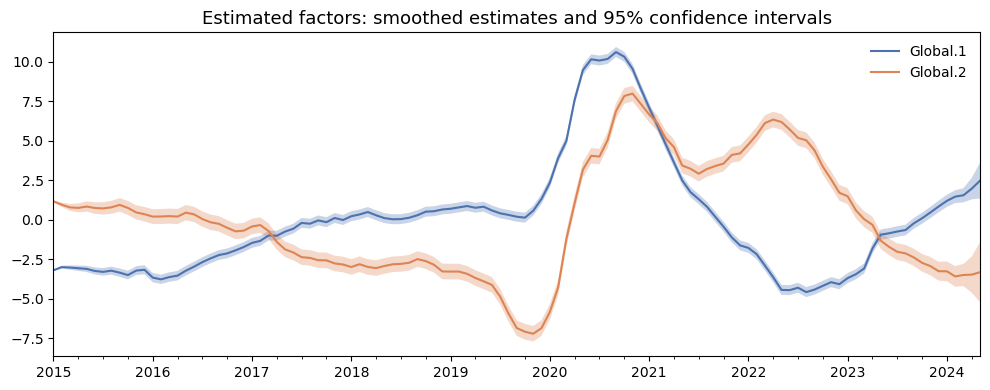

In [12]:
# Declaration
factor_names = ['Global.1', 'Global.2']


# Compute 95% confidence intervals
mean = results.factors.smoothed[factor_names]
std   = pd.concat([results.factors.smoothed_cov.loc[name, name] for name in factor_names], axis=1)
crit  = norm.ppf(1 - 0.05 / 2)
lower = mean - crit * std
upper = mean + crit * std


with sns.color_palette('deep'):
    fig, ax = plt.subplots(figsize=(10, 4))
    mean.plot(ax=ax)
    
    for name in factor_names:
        ax.fill_between(mean.index, lower[name], upper[name], alpha=0.3)

    plt.title('Estimated factors: smoothed estimates and 95% confidence intervals', fontsize=13)
    plt.legend(fontsize=10, edgecolor="white")
    
    fig.tight_layout()
    plt.plot()

## $R^2$ of individual factors
We can also review which are the most relevant indicators in each group/factor:

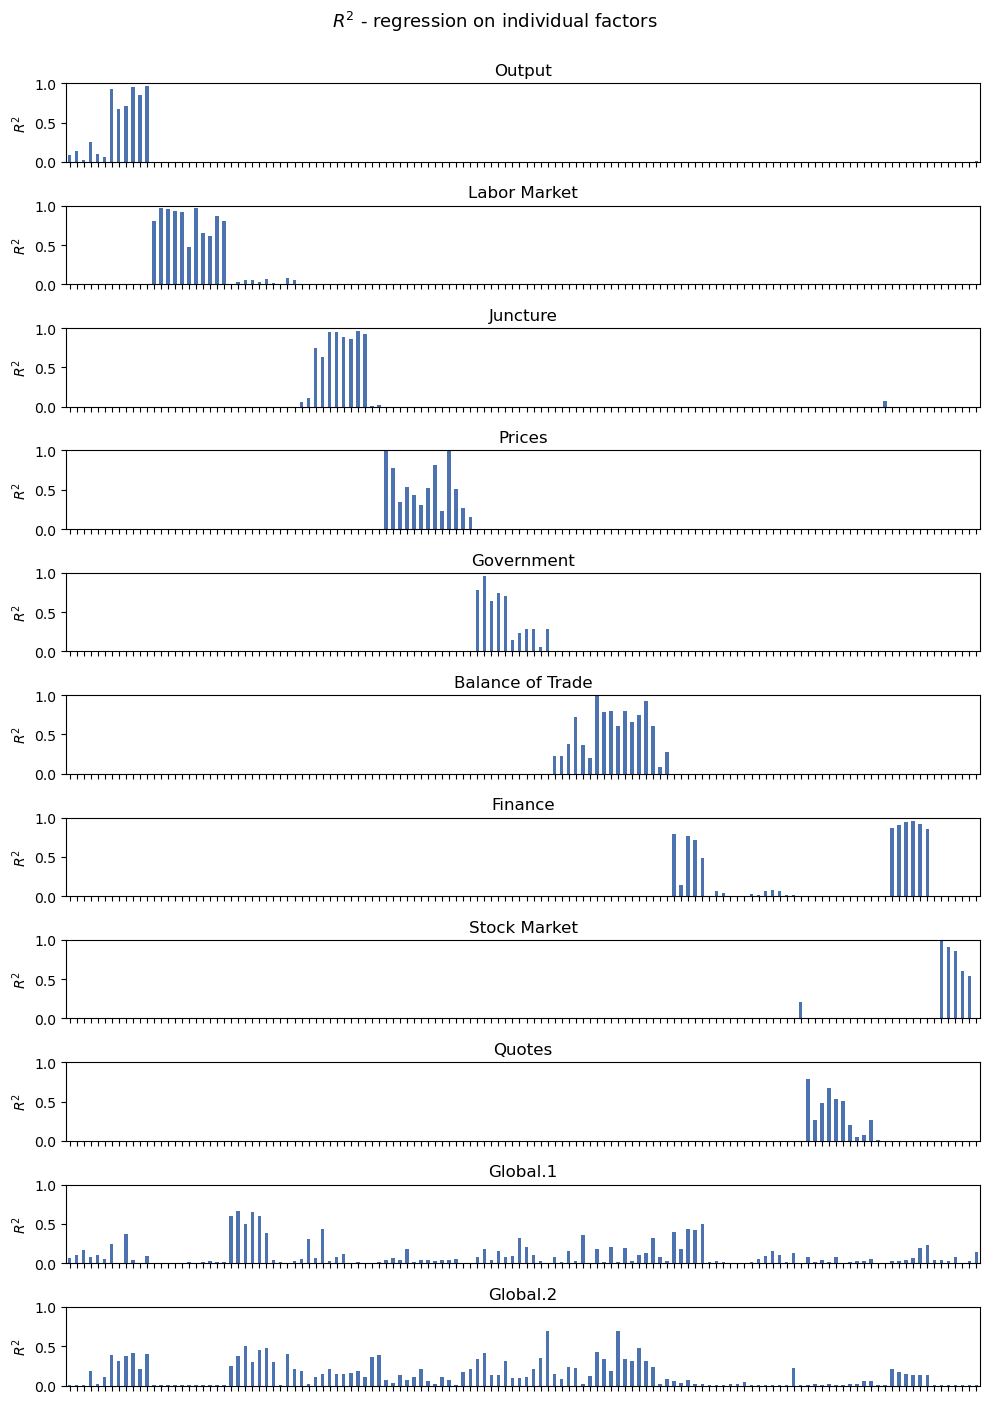

In [13]:
with sns.color_palette('deep'):
    fig = results.plot_coefficients_of_determination(method='individual', figsize=(10, 14))
    fig.suptitle(r'$R^2$ - regression on individual factors', fontsize=13, y=1)
    fig.tight_layout()

## Forecasting
Then, with the latest monthly data, the nowcasting models allow us to forecast with all the information possible:

In [14]:
first_period    = str(df_q.index[0])
last_period     = str(df_q.index[-1])
forecast_period = '2025Q4' # To define

print(f'Last oficial value on: {last_period}, and we estimated until {forecast_period}')

Last oficial value on: 2023Q4, and we estimated until 2025Q4


In [15]:
# Monthly GDP Growth estimated to Quarterly
forecast = results.forecast(forecast_period)['GDP Growth'].resample('Q').last()
h        = len(forecast)


# New GDP DataFrame ========================================================================
new_periods = pd.period_range(start=first_period, end=forecast_period, freq='Q')
df_q_f      = pd.DataFrame(index=new_periods, columns=['Real GDP', 'GDP Growth'])

# GDP Growth
df_q_f.loc[:last_period, 'Real GDP']   = df_q['Real GDP']
df_q_f.loc[:last_period, 'GDP Growth'] = df_q['GDP Growth']
df_q_f.loc[-h:, 'GDP Growth'] = forecast

# GDP 2024Q1 -> Only for this quarter
df_q_f.loc['2024Q1', 'GDP Growth'] = float(
    results.predict()[results.predict().index=='2024-03']['GDP Growth']
)

# Real GDP
last_real_gdp = df_q_f.loc[df_q_f['Real GDP'].last_valid_index(), 'Real GDP']

for i in range(len(df_q_f)):
    if df_q_f.index[i] >= pd.Period(last_period):
        previous_real_gdp = df_q_f.loc[df_q_f.index[i-4], 'Real GDP']
        gdp_growth = df_q_f.loc[df_q_f.index[i], 'GDP Growth']
        df_q_f.loc[df_q_f.index[i], 'Real GDP'] = previous_real_gdp * (1 + gdp_growth / 100)

df_q_f['Real GDP'] = df_q_f['Real GDP'].fillna(method='ffill')


# Check
print(f'\nReal GDP and Real GDP Growth\n(oficial until {last_period} and forecast):\n')
df_q_f.tail(12)


Real GDP and Real GDP Growth
(oficial until 2023Q4 and forecast):



,Real GDP,GDP Growth
2023Q1,132691.247000,-0.366922
2023Q2,140431.786000,-0.517729
2023Q3,142256.054000,-0.919111
2023Q4,148881.490000,-0.394922
2024Q1,134895.767783,1.661391
2024Q2,143223.712369,1.988101
2024Q3,143151.662508,0.629575
2024Q4,147981.069724,-0.60479
2025Q1,132965.445218,-1.430973
2025Q2,140692.814679,-1.767094


In [16]:
print(f'\nAnnual forecast:\n')
pd.DataFrame(
    {
        'Real GDP': np.round( df_q_f['Real GDP'].resample('Y').sum(), 0),
        'GDP Growth': np.round( df_q_f['Real GDP'].resample('Y').sum().pct_change() * 100, 2)
    }
).loc['2022':]


Annual forecast:



,Real GDP,GDP Growth
2022,567390.0,2.68
2023,564261.0,-0.55
2024,569252.0,0.88
2025,561262.0,-1.40


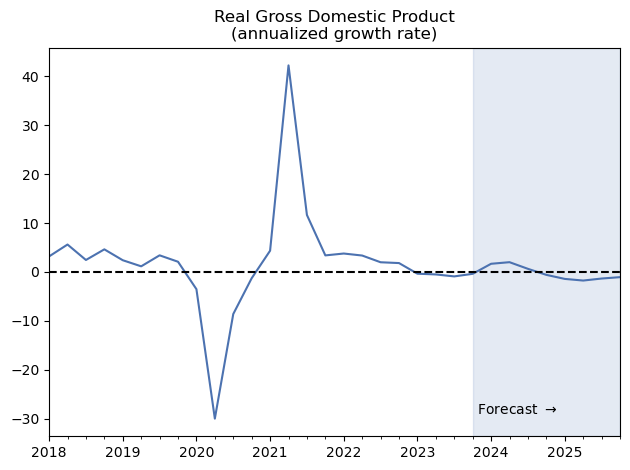

GDP Growth / Forecast: 
2023Q4   -0.394922
2024Q1    1.661391
2024Q2    1.988101
2024Q3    0.629575
2024Q4    -0.60479
2025Q1   -1.430973
2025Q2   -1.767094
2025Q3   -1.356795
2025Q4   -1.072532
Freq: Q-DEC, Name: GDP Growth, dtype: object


In [17]:
xmin = '2018Q1'
xmax = '2025Q4'


with sns.color_palette('deep'):
    fig = plt.plot(figsize=(8, 5), dpi=600)

    # Plot GDP growth data: historic and forecast
    df_q_f.loc[xmin:xmax, 'GDP Growth'].plot()
    plt.title('Real Gross Domestic Product\n(annualized growth rate)')
    plt.axhline(y=0, color='black', linestyle='--')
   
    # Fill
    ylim = plt.ylim()
    plt.fill_between(df_q_f.loc[last_period:].index, ylim[0], ylim[1], alpha=0.15, color='C0')
    plt.annotate(r' Forecast $\rightarrow$', (last_period, ylim[0] + 0.1 * ylim[1]))
    plt.ylim(ylim[0], ylim[1])

    plt.tight_layout()
    plt.show()


print('GDP Growth / Forecast: ')
print(df_q_f['GDP Growth'].tail(h+2))

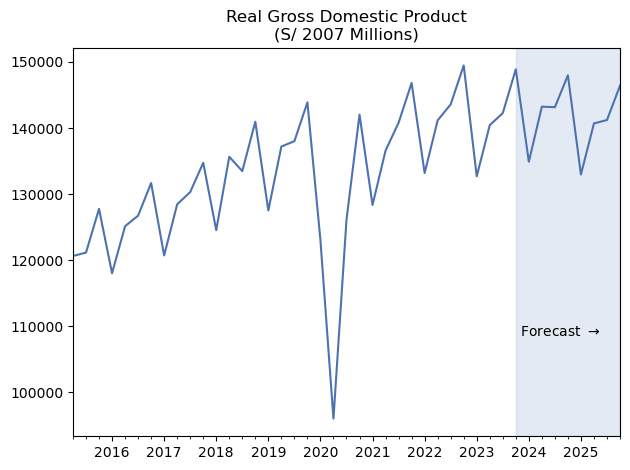

Real GDP / Forecast: 
2023Q4    148881.490000
2024Q1    134895.767783
2024Q2    143223.712369
2024Q3    143151.662508
2024Q4    147981.069724
2025Q1    132965.445218
2025Q2    140692.814679
2025Q3    141209.388329
2025Q4    146393.924908
Freq: Q-DEC, Name: Real GDP, dtype: float64


In [18]:
xmin = '2015Q1'
xmax = '2025Q4'


with sns.color_palette('deep'):
    fig = plt.plot(figsize=(8, 5), dpi=600)

    # Plot GDP growth data: historic and forecast
    df_q_f.loc[xmin:xmax, 'Real GDP'].plot()
    plt.title('Real Gross Domestic Product\n(S/ 2007 Millions)')
   
    # Fill
    ylim = plt.ylim()
    plt.fill_between(df_q_f.loc[last_period:].index, ylim[0], ylim[1], alpha=0.15, color='C0')
    plt.annotate(r' Forecast $\rightarrow$', (last_period, ylim[0] + 0.1 * ylim[1]))
    plt.ylim(ylim[0], ylim[1])

    plt.tight_layout()
    plt.show()


print('Real GDP / Forecast: ')
print(df_q_f['Real GDP'].tail(h+2))

## Updated forecast across the months
Since past datasets has been recorded, it is possible to analyze how forecasts of particular quarters have changed as more information is obtained:

In [19]:
vintage_results = {}
quarter_to_predict = '2024Q2'


for date in list(dta.keys()):

    # Get updated data for the vintage
    updated_endog_m = dta[date].loc[first_period:, :]
    updated_endog_q = dta_gdp[date].loc[first_period:, ['GDP Growth']]

    # Get updated results
    vintage_results[date] = results.apply(
        updated_endog_m,
        endog_quarterly=updated_endog_q
    )

# Saving results
forecasts = {
    vintage: res.forecast(forecast_period)['GDP Growth'].resample('Q').last()\
        .loc[quarter_to_predict] for vintage, res in vintage_results.items()
}

forecasts = pd.Series(
    list(forecasts.values()),
    index=pd.PeriodIndex(forecasts.keys(), freq='M')
)

# Print our forecast of the Real GDP Growth across all dates
for vintage, value in forecasts.items():
    print(f'{vintage} forecast of the Real GDP growth in {quarter_to_predict}:'
          f' {value:.2f}%'
    )

2023-05 forecast of the Real GDP growth in 2024Q2: 3.80%
2023-06 forecast of the Real GDP growth in 2024Q2: 2.45%
2023-07 forecast of the Real GDP growth in 2024Q2: 1.88%
2023-08 forecast of the Real GDP growth in 2024Q2: 2.05%
2023-09 forecast of the Real GDP growth in 2024Q2: 1.42%
2023-10 forecast of the Real GDP growth in 2024Q2: 1.91%
2023-11 forecast of the Real GDP growth in 2024Q2: 0.86%
2023-12 forecast of the Real GDP growth in 2024Q2: 1.07%
2024-01 forecast of the Real GDP growth in 2024Q2: 1.07%
2024-02 forecast of the Real GDP growth in 2024Q2: 1.85%
2024-03 forecast of the Real GDP growth in 2024Q2: 1.98%
2024-04 forecast of the Real GDP growth in 2024Q2: 2.12%
2024-05 forecast of the Real GDP growth in 2024Q2: 2.01%
